In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import esa_snappy
from esa_snappy import Product
from esa_snappy import ProductIO
from esa_snappy import ProductUtils
from esa_snappy import WKTReader
from esa_snappy import HashMap
from esa_snappy import GPF


# For shapefiles

import shapefile
import pygeoif

Error while parsing JAI registry file "file:/home/jovyan/snap/snap/modules/ext/org.esa.snap.snap-gpf/org-jaitools/jt-vectorize.jar!/META-INF/registryFile.jai" :
Error in registry file at line number #4
A descriptor is already registered against the name "Vectorize" under registry mode "rendered"
SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.


In [6]:
path_to_sentinel_data = "/home/jovyan/GEOS_657_Labs/2025/S1A_IW_GRDH_1SDV_20240818T234813_20240818T234838_055274_06BD20_1FBC.SAFE.zip"
product = ProductIO.readProduct(path_to_sentinel_data)

INFO: eu.esa.sar.commons.io.ImageIOFile: Using FileCacheImageInputStream
INFO: eu.esa.sar.commons.io.ImageIOFile: Using FileCacheImageInputStream


In [7]:
width = product.getSceneRasterWidth()
print("Width: {} px".format(width))
height = product.getSceneRasterHeight()
print("Height: {} px".format(height))
name = product.getName()
print("Name: {}".format(name))
band_names = product.getBandNames()
print("Band names: {}".format(", ".join(band_names)))

Width: 25619 px
Height: 16736 px
Name: S1A_IW_GRDH_1SDV_20240818T234813_20240818T234838_055274_06BD20_1FBC
Band names: Amplitude_VH, Intensity_VH, Amplitude_VV, Intensity_VV


In [9]:
def plotBand(product, band, vmin, vmax):
    band = product.getBand(band)
    w = band.getRasterWidth()
    h = band.getRasterHeight()
    print(w, h)
    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)
    band_data.shape = h, w
    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary, vmin=vmin, vmax=vmax)
    return imgplot

In [10]:
parameters = HashMap()
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
parameters.put('orbitType', 'Sentinel Precise (Auto Download)')
parameters.put('polyDegree', '3')
parameters.put('continueOnFail', 'false')
apply_orbit_file = GPF.createProduct('Apply-Orbit-File', parameters, product)

INFO: org.esa.snap.engine_utilities.download.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/orbits/Sentinel-1/POEORB/S1A/2024/08/S1A_OPER_AUX_POEORB_OPOD_20240907T070602_V20240817T225942_20240819T005942.EOF.zip



100% done.


In [18]:
from shapely.geometry import shape
from shapely.ops import unary_union

r = shapefile.Reader("/home/jovyan/GEOS_657_Labs/2025/Udaipur_South_East_tripura_LAND_USA.shp")

g = []
for s in r.shapes():
    g.append(shape(s.__geo_interface__))

m = unary_union(g)
wkt = str(m.convex_hull.wkt)
print(wkt)

POLYGON ((91.45315536752622 23.367564503499068, 91.44302647689045 23.368061016502736, 91.44114888311452 23.368278593082664, 91.42019484401692 23.374108638902612, 91.38689718625619 23.40166893407411, 91.38506788427549 23.40347495800296, 91.38495539977197 23.403876735523, 91.38450559845467 23.406098003420198, 91.37677466551844 23.444500367797787, 91.37516895388416 23.517849146720778, 91.39754914147977 23.584770413423882, 91.43766040020493 23.617721505532735, 91.4702132 23.5925343, 91.5565036 23.5086191, 91.58678165254359 23.386841973823, 91.57512909733003 23.383841692939825, 91.45315536752622 23.367564503499068))


In [21]:
SubsetOp = esa_snappy.jpy.get_type('org.esa.snap.core.gpf.common.SubsetOp')
bounding_wkt = wkt
geometry = WKTReader().read(bounding_wkt)
HashMap = esa_snappy.jpy.get_type('java.util.HashMap')
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('geoRegion', geometry)
product_subset = esa_snappy.GPF.createProduct('Subset', parameters,
apply_orbit_file)


100% done.


Width: 2389 px
Height: 2673 px
Band names: Amplitude_VH, Intensity_VH, Amplitude_VV, Intensity_VV
java.awt.Dimension[width=2389,height=2673]
2389 2673


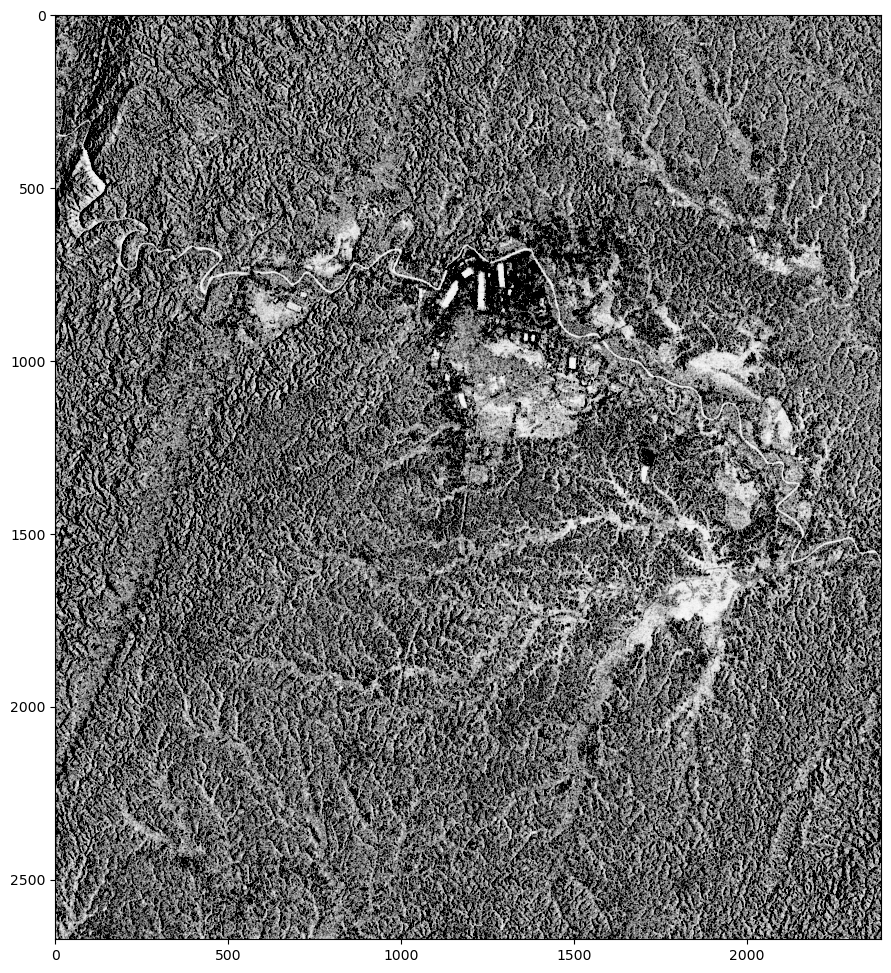

In [22]:
width = product_subset.getSceneRasterWidth()
print("Width: {} px".format(width))
height = product_subset.getSceneRasterHeight()
print("Height: {} px".format(height))
band_names = product_subset.getBandNames()
print("Band names: {}".format(", ".join(band_names)))
band = product_subset.getBand(band_names[0])
print(band.getRasterSize())
plotBand(product_subset, "Intensity_VV", 0, 100000)

In [23]:
parameters = HashMap()
parameters.put('outputSigmaBand', True)
parameters.put('sourceBands', 'Intensity_VV')
parameters.put('selectedPolarisations', "VV")
parameters.put('outputImageScaleInDb', False)
product_calibrated = GPF.createProduct("Calibration", parameters,
product_subset)


100% done.


2389 2673


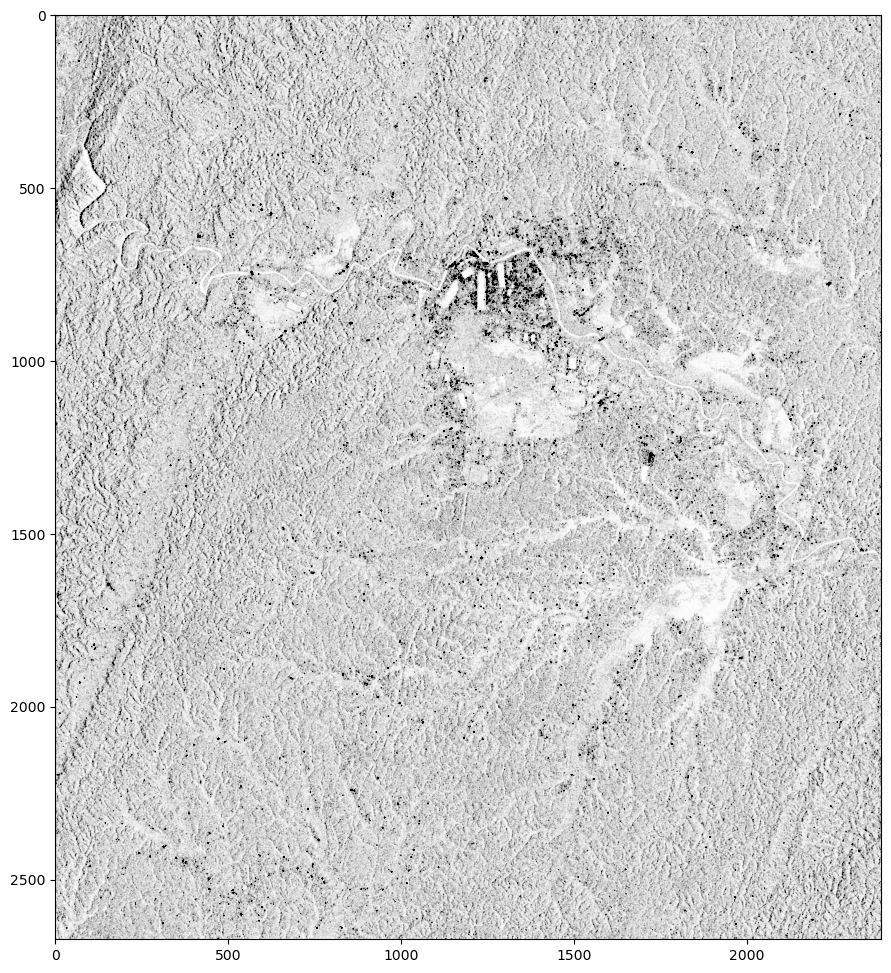

In [24]:
plotBand(product_calibrated, "Sigma0_VV", 0, 1)


2389 2673
100% done.


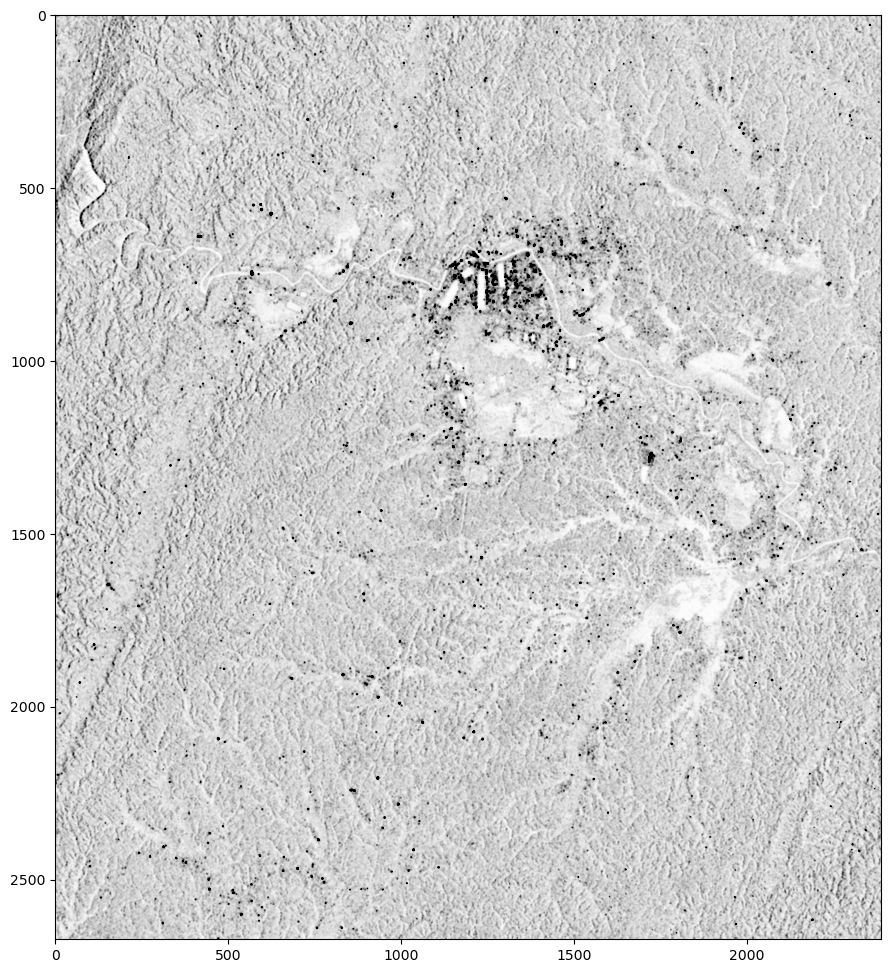

In [26]:
filterSizeY = '5'
filterSizeX = '5'
parameters = HashMap()
parameters.put('sourceBands', 'Sigma0_VV')
parameters.put('filter', 'Lee')
parameters.put('filterSizeX', filterSizeX)
parameters.put('filterSizeY', filterSizeY)
parameters.put('dampingFactor', '2')
parameters.put('estimateENL', 'true')
parameters.put('enl', '1.0')
parameters.put('numLooksStr', '1')
parameters.put('targetWindowSizeStr', '3x3')
parameters.put('sigmaStr', '0.9')
parameters.put('anSize', '50')
speckle_filter = esa_snappy.GPF.createProduct('Speckle-Filter', parameters,
product_calibrated)
plotBand(speckle_filter, 'Sigma0_VV', 0, 1)


100% done.
3083 3114


INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving https://download.esa.int/step/auxdata/dem/SRTM90/tiff/srtm_55_08.zip
INFO: org.esa.snap.engine_utilities.download.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/dem/egm96/ww15mgh_b.zip


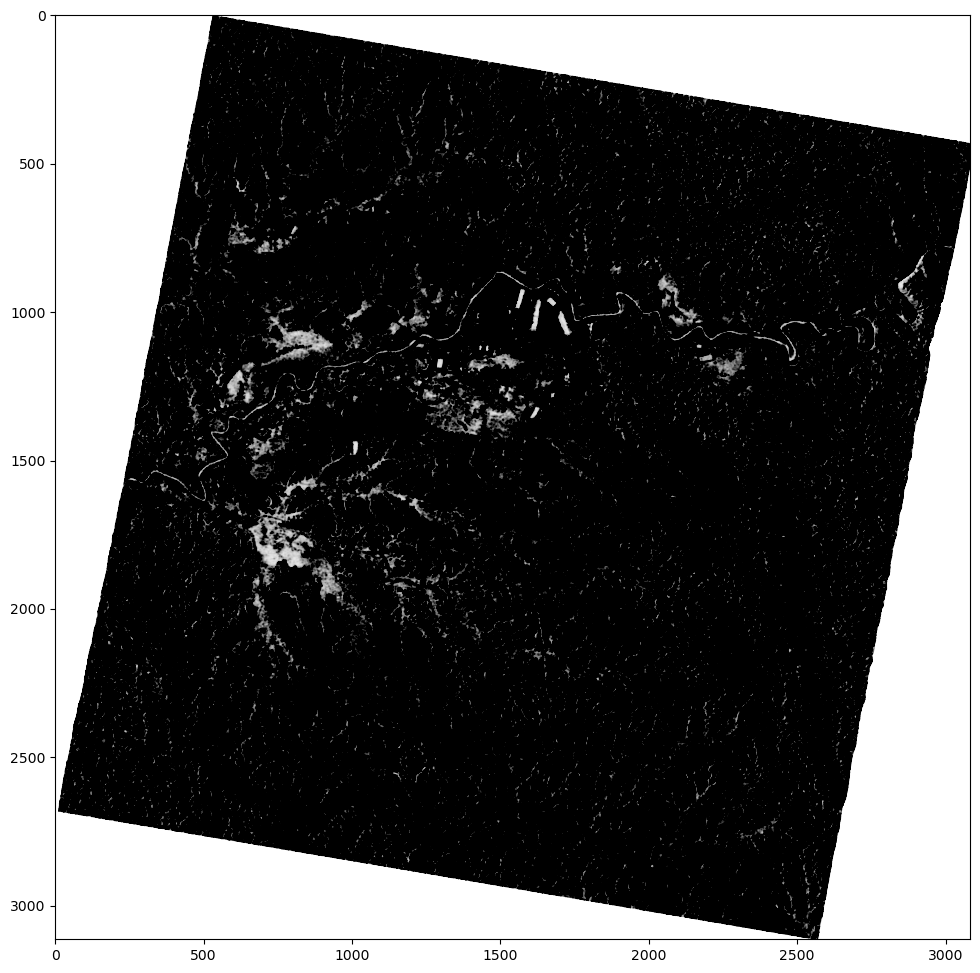

In [27]:
parameters = HashMap()
parameters.put('demName', 'SRTM 3Sec')
parameters.put('pixelSpacingInMeter', 10.0)
parameters.put('sourceBands', 'Sigma0_VV')
speckle_filter_tc = GPF.createProduct("Terrain-Correction", parameters,
speckle_filter)
plotBand(speckle_filter_tc, 'Sigma0_VV', 0, 0.1)

In [35]:
parameters = HashMap()
BandDescriptor = esa_snappy.jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')
targetBand = BandDescriptor()
targetBand.name = 'Sigma0_VV_Flooded'
targetBand.type = 'uint8'
targetBand.expression = '(Sigma0_VV < 1.15E-1) ? 1 : 0'
targetBands = esa_snappy.jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
targetBands[0] = targetBand
parameters.put('targetBands', targetBands)
flood_mask = GPF.createProduct('BandMaths', parameters, speckle_filter_tc)


100% done.


3083 3114


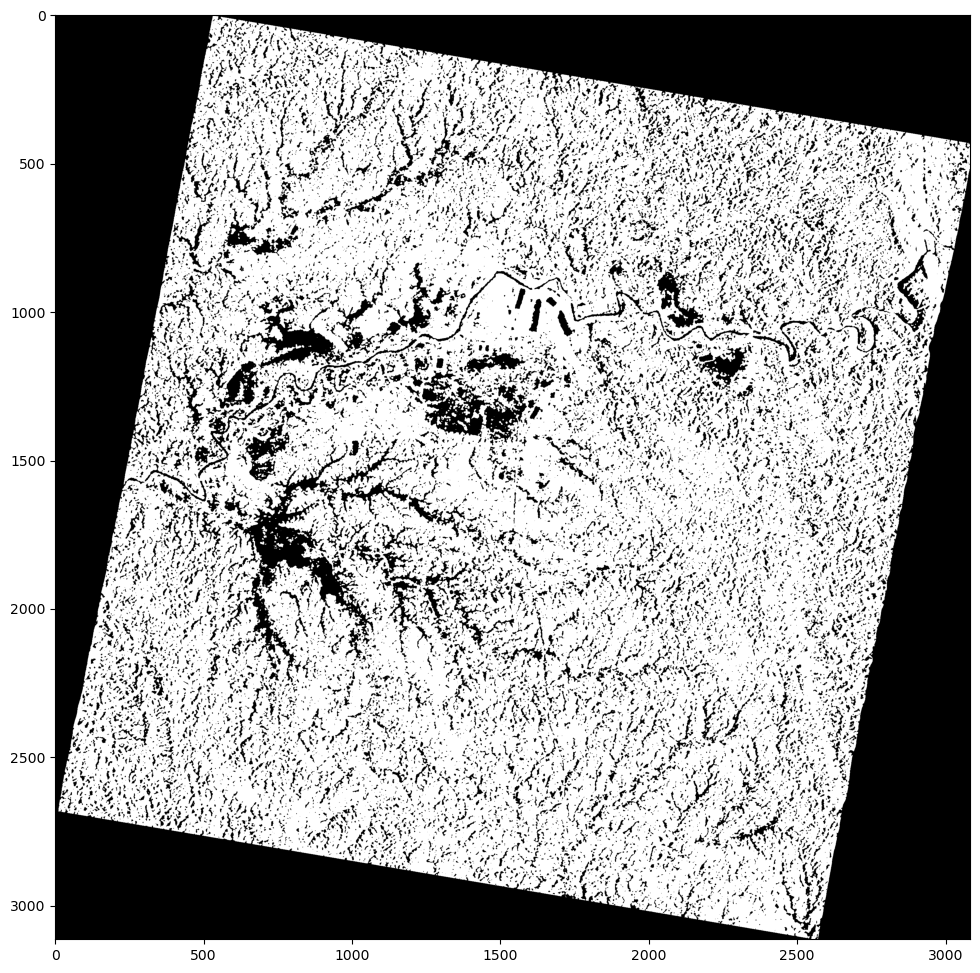

In [36]:
plotBand(flood_mask, 'Sigma0_VV_Flooded', 0, 1)

In [37]:
parameters = HashMap()
parameters.put("landCoverNames", "GlobCover")
mask_with_land_cover = GPF.createProduct('AddLandCover', parameters,
flood_mask)


50%100% done.


In [39]:
parameters = HashMap()
BandDescriptor = esa_snappy.jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')
targetBand = BandDescriptor()
targetBand.name = 'BinaryWater'
targetBand.type = 'uint8'
targetBand.expression = '(land_cover_GlobCover == 210) ? 0 : 1'
targetBands = esa_snappy.jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
targetBands[0] = targetBand
parameters.put('targetBands', targetBands)
water_mask = GPF.createProduct('BandMaths', parameters, mask_with_land_cover)


100% done.


3083 3114


INFO: org.esa.snap.engine_utilities.download.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/landcover/globcover/globecover_1.tif.zip
INFO: org.esa.snap.engine_utilities.download.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/landcover/globcover/globecover_2.tif.zip
INFO: org.esa.snap.engine_utilities.download.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/landcover/globcover/globecover_3.tif.zip
INFO: org.esa.snap.engine_utilities.download.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/landcover/globcover/globecover_4.tif.zip
INFO: org.esa.snap.engine_utilities.download.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/landcover/globcover/globecover_5.tif.zip
INFO: org.esa.snap.engine_utilities.download.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/landcover/globcover/globecover_6.tif.zip
INFO: org.esa.snap.engine_utilities.download.DownloadableContentImpl: 

BinaryWater
Sigma0_VV_Flooded


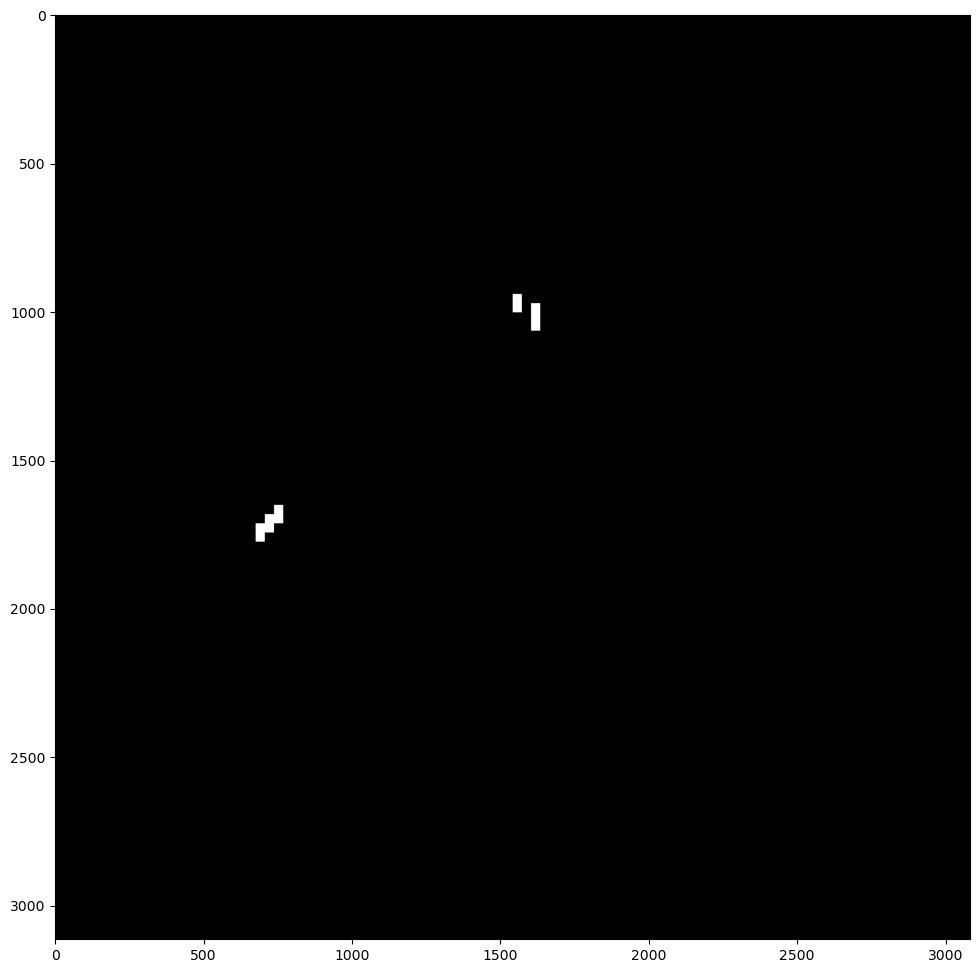

In [40]:
plotBand(water_mask, 'BinaryWater', 0, 1)
print(",".join(water_mask.getBandNames()))
print(",".join(flood_mask.getBandNames()))

In [42]:
parameters = HashMap()
BandDescriptor = esa_snappy.jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')
try:
    water_mask.addBand(flood_mask.getBand("Sigma0_VV_Flooded"))
except:
    pass
    
targetBand = BandDescriptor()
targetBand.name = 'Sigma0_VV_Flood_Masked'
targetBand.type = 'uint8'
targetBand.expression = '(BinaryWater == 1 && Sigma0_VV_Flooded == 1) ? 1 : 0'
targetBands = esa_snappy.jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
targetBands[0] = targetBand
parameters.put('targetBands', targetBands)
water_mask2 = GPF.createProduct('BandMaths', parameters, water_mask)


100% done.


3083 3114


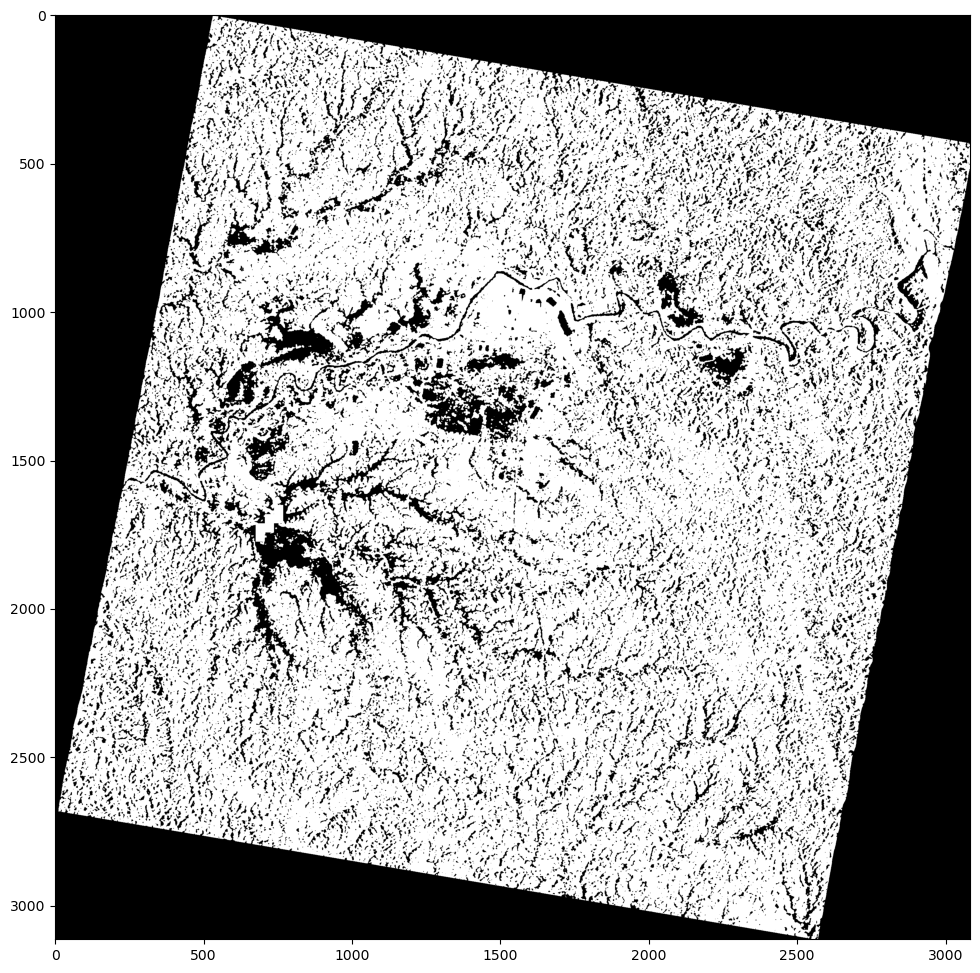

In [43]:
plotBand(water_mask2, 'Sigma0_VV_Flood_Masked', 0, 1)

In [50]:
#import os
#os.makedirs("/home/jovyan/FLOOD_DATASET", exist_ok=True)

#os.path.exists("/home/jovyan/FLOOD_DATASET/final_mask.tif")


ProductIO.writeProduct(water_mask2, "/home/jovyan/FLOOD_DATASET/final_mask", 'GeoTIFF')
os.path.exists("/home/jovyan/FLOOD_DATASET/final_mask.tif")

True

In [49]:
def listParams(operator_name):
    GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
    op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator_name)
    print('Op name:', op_spi.getOperatorDescriptor().getName())
    print('Op alias:', op_spi.getOperatorDescriptor().getAlias())
    param_Desc = op_spi.getOperatorDescriptor().getParameterDescriptors()
    for param in param_Desc:
        print(param.getName(), "or", param.getAlias())
        
listParams("AddLandCover")

Op name: org.esa.snap.landcover.gpf.AddLandCoverOp
Op alias: AddLandCover
landCoverNames or None
externalFiles or None
resamplingMethod or None
